In [1]:
# Built-in Libraries
import os
import re
import io
import math
import time
import random
import shutil
import errno
import tarfile
import logging
import warnings
import collections
import fnmatch
import json
from glob import glob
from math import log10
from random import randrange

# Display & Widgets
import ipywidgets as widgets
from IPython.display import display

# CV2
import cv2
from cv2 import imshow

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Image & Metrics
from PIL import Image
from skimage import measure
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# NumPy
import numpy as np

# Requests & Hashing
import requests
import hashlib

# Progress Bars & Functional
from tqdm import tqdm
from functools import partial

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch Data
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

# Torch Init & Layers
from torch.nn.init import trunc_normal_, _calculate_fan_in_and_fan_out

# TorchVision Core
import torchvision
import torchvision.utils as utils
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.datasets import Cityscapes
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as FT

# TorchVision Datasets
from torchvision.datasets.utils import download_and_extract_archive

# TorchVision Models
from torchvision.models import vgg16, vit_b_16, ViT_B_16_Weights
from torchvision.models.detection import (
    maskrcnn_resnet50_fpn_v2 as base,
    MaskRCNN_ResNet50_FPN_V2_Weights as base_init
)
from torchvision.models.detection.anchor_utils import AnchorGenerator

# TorchVision Drawing & Operations
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.ops import (
    MultiScaleRoIAlign,
    masks_to_boxes,
)
from torchvision.ops.feature_pyramid_network import (
    LastLevelMaxPool,
    FeaturePyramidNetwork
)

# External Libraries
from timm.layers import to_2tuple, trunc_normal_


In [2]:
# !zip -r model_run1.zip "/kaggle/input/seg_depth/pytorch/default/1/log20/CityScapes/0404_GLPDepthWithSegmentation/events.out.tfevents.1743775902.6e42045e3d2c"

In [3]:
# !mv model_run1.zip /kaggle/working/

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
root = "/kaggle/input/prepcityscapes"

In [6]:
glob(os.path.join(root, 'leftImg8bit', 'train', '*.png'))[0], glob(os.path.join(root, 'gtFineI', 'train', '*instanceIds.png'))[0] , glob(os.path.join('/kaggle/input/prepcityscapesdepth/', 'depth', 'train', '*.png'))[0] 

('/kaggle/input/prepcityscapes/leftImg8bit/train/jena_000044_000019_leftImg8bit.png',
 '/kaggle/input/prepcityscapes/gtFineI/train/strasbourg_000001_023271_gtFine_instanceIds.png',
 '/kaggle/input/prepcityscapesdepth/depth/train/ulm_000083_000019_depth.png')

# Lables

In [7]:
from __future__ import print_function, absolute_import, division
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#  dictionaries for a fast lookup

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name

In [8]:
# Print all the labels
print("List of cityscapes labels:")
print("")
print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval' ))
print("    " + ('-' * 98))
for label in labels:
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval ))
print("")

print("Example usages:")

# Map from name to label
name = 'car'
id   = name2label[name].id
print("ID of label '{name}': {id}".format( name=name, id=id ))

# Map from ID to label
category = id2label[id].category
print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

# Map from trainID to label
trainId = 0
name = trainId2label[trainId].name
print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |      19 |           void |          0 |            0 |            1
              ego vehicle |   1 |      19 |           void |          0 |            0 |            1
     rectification border |   2 |      19 |           void |          0 |            0 |            1
               out of roi |   3 |      19 |           void |          0 |            0 |            1
                   static |   4 |      19 |           void |          0 |            0 |            1
                  dynamic |   5 |      19 |           void |          0 |            0 |            1
                   ground |   6 |      19 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

In [9]:
# # create depth folder
# depth_folder = os.path.join('/kaggle/working/', 'depth')
# if not os.path.exists(depth_folder):
#     os.mkdir(depth_folder)

In [10]:
# len(glob('/kaggle/working/depth/train/*.png'))

In [11]:
# plt.imshow(cv2.imread('/kaggle/working/depth/train/aachen_000000_000019_depth.png', cv2.IMREAD_UNCHANGED).astype(np.float32))

In [12]:
def compute_depth(disparity : np.ndarray, 
                  w : int = 2048, 
                  h : int = 1024, 
                  inpaint_radius : int = None, 
                  baseline : float = 0.209313, 
                  f : float = 2262.52, 
                  max_depth : int = 500) -> np.ndarray:
    """ Computes smooth depth map from disparity 
        Inputs:
            disparity - uint16 dispairty image, 
            w - disparity width, 
            h - disparity height, 
            inpaint_radius - inpainting radius, 
            baseline stereo baseline distance (meters), 
            f - camera focal length (pixels) 
                For CityScapes:
                    fx = 2262.52 
                    fy = 2265.3017905988554 
            max_depth - maximum valid depth (meters)
        Outputs: 
            depth - computed depth map
        """
    
    """ NOTE: For training, need to process all input images just like this! """
    # crop noisy areas and resize
    disparity = cv2.resize(disparity[50:int(h*0.8), 100:], (w,h))

    # inpaint invalid disparity
    if inpaint_radius:
        disparity = cv2.inpaint(disparity, 
                                np.uint8(255*(disparity <= 1)), 
                                inpaintRadius=inpaint_radius, 
                                flags=cv2.INPAINT_TELEA)

    # blur to reduce noise
    disparity = cv2.medianBlur(disparity, 5)

    # scale to get True Disparity
    disparity = disparity.astype(np.float32)
    disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

    # compute depth
    depth = baseline * f / (disparity + 0.1)

    # clip and return
    return np.clip(depth, 0, max_depth)

# Depth Coversion

In [13]:
# class CityScapes():
#     def __init__(self, root, split='train', return_paths=False):
#         self.root = root
#         self.return_paths = return_paths

#         self.rgb_paths = sorted(glob(os.path.join(root, 'leftImg8bit', split, '*.png')))
#         self.mask_paths = sorted(glob(os.path.join(root, 'gtFineI', split, '*instanceIds.png')))
#         # self.mask_paths = glob(os.path.join(root, 'gtFineS', split, '**\*labelIds.png'))
#         self.disparity_paths = sorted(glob(os.path.join('/kaggle/working/', 'disparity', split, '*.png')))


#     def __getitem__(self, idx):
#         rgb_image = cv2.cvtColor(cv2.imread(self.rgb_paths[idx]), cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED)
#         disparity = cv2.imread(self.disparity_paths[idx], cv2.IMREAD_UNCHANGED)

#         if self.return_paths:
#             return rgb_image, (mask, disparity), self.rgb_paths[idx], (self.mask_paths[idx], self.disparity_paths[idx])

#         return rgb_image, (mask, disparity)
    
#     def __len__(self):
#         return len(self.rgb_paths)

In [14]:
# rm -rf /kaggle/working/depth/test /kaggle/working/depth/val

In [15]:
# for split in ( 'val', 'test'):
#     # create dir for split
#     # print(split)
#     split_dir = os.path.join(depth_folder, split)
#     if not os.path.exists(split_dir):
#         os.mkdir(split_dir)

#     # get dataset
#     dataset = CityScapes(root, split=split, return_paths=True)

#     # get depth map for all disparities
#     for i in tqdm(range(len(dataset)), desc=f"Processing {split}"):
#         _, (_, disparity), _, (_, disparity_path) = dataset[i]
#         # print("disparity_path: ",disparity_path)
#         depth = compute_depth(disparity)

#         savepath = disparity_path.replace('disparity', 'depth')
#         dirname, _= os.path.split(savepath)
#         # print("dirname: ",dirname)
#         if not os.path.exists(dirname):
#             os.mkdir(dirname)

#         cv2.imwrite(savepath, depth)


# Dataset

In [16]:
# sorted(glob(os.path.join(root, 'gtFineP', 'train', '*_polygons.json')))

In [17]:
import os
from glob import glob
import numpy as np
import cv2
from torch.utils.data import Dataset
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      20 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      20 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      20 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      20 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      20 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      20 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      20 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      20 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

class CityScapesDataset(Dataset):
    def __init__(self, root, transform=None, split='train', label_map='trainId', crop=True):
        self.root = root
        self.transform = transform
        self.label_map = label_map
        self.crop = crop

        self.left_paths = sorted(glob(os.path.join(root, 'leftImg8bit', split, '*.png')))
        self.mask_paths = sorted(glob(os.path.join(root, 'gtFine', split, '*.png')))
        self.depth_paths = sorted(glob(os.path.join('/kaggle/input/prepcityscapesdepth', 'depth', split, '*.png')))
        self.json_paths = sorted(glob(os.path.join('/kaggle/input/prepcityscapespolygon', 'gtFineP', split, '*_polygons.json')))

        print("Sample image path:", self.left_paths[0])
        print("Sample mask path:", self.mask_paths[0])
        print("Sample depth path:", self.depth_paths[0])

        # Create LUTs for remapping
        self.id_to_trainid_lut = self._create_lut('trainId')
        self.id_to_categoryid_lut = self._create_lut('categoryId')

        # Human-readable mappings (optional)
        self.id_2_name = {-1: 'unlabeled'}
        self.trainid_2_name = {19: 'unlabeled'}

        for lbl in labels:
            if lbl.trainId != 19:
                self.trainid_2_name[lbl.trainId] = lbl.name
            if lbl.id > 0:
                self.id_2_name[lbl.id] = lbl.name

    def _create_lut(self, target='trainId'):
        lut = np.full((256,), 19, dtype=np.int16)  # Supports -1 safely
        for lbl in labels:
            value = getattr(lbl, target)
            lut[lbl.id] = value
        return lut


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.uint8)
        depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.float32)

        if self.crop:
            left = left[:800, :, :]
            mask = mask[:800, :]
            depth = depth[:800, :]

        # Apply label remapping via LUT
        if self.label_map == 'id':
            pass  # keep original label ids
        elif self.label_map == 'trainId':
            print("Shape Before:", mask.shape)
            mask = self.id_to_trainid_lut[mask]
            print("Shape After:", mask.shape)
        elif self.label_map == 'categoryId':
            mask = self.id_to_categoryid_lut[mask]
        else:
            raise ValueError(f"Unknown label_map: {self.label_map}")

        # Make sure depth is non-negative
        depth[depth < 0] = 0

        sample = {'left': left, 'mask': mask, 'depth': depth}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.left_paths)


In [18]:
dataset = CityScapesDataset(root, split='train')

Sample image path: /kaggle/input/prepcityscapes/leftImg8bit/train/aachen_000000_000019_leftImg8bit.png
Sample mask path: /kaggle/input/prepcityscapes/gtFine/train/aachen_000000_000019_gtFine_labelIds.png
Sample depth path: /kaggle/input/prepcityscapesdepth/depth/train/aachen_000000_000019_depth.png


In [19]:
sample = dataset.__getitem__(198)

Shape Before: (800, 2048)
Shape After: (800, 2048)


In [20]:
sample['left'].shape, sample['mask'].shape, sample['depth'].shape

((800, 2048, 3), (800, 2048), (800, 2048))

In [21]:
"""
# rgb_image, mask, disparity = dataset.__getitem__(130)
sample = dataset.__getitem__(198)

_, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(sample['left'])
ax[1].imshow(sample['mask'], cmap='nipy_spectral')
ax[2].imshow(sample['depth'], cmap='plasma')
"""

"\n# rgb_image, mask, disparity = dataset.__getitem__(130)\nsample = dataset.__getitem__(198)\n\n_, ax = plt.subplots(1, 3, figsize=(20, 8))\nax[0].imshow(sample['left'])\nax[1].imshow(sample['mask'], cmap='nipy_spectral')\nax[2].imshow(sample['depth'], cmap='plasma')\n"

In [22]:
"""
unique_ids = torch.unique(sample['mask'])
print("Unique Object IDs:", unique_ids)
"""
"""
Unique Object IDs: [  0   1   2   3   4   6   7   8   9  11  17  19  20  21  22  23 144 145
 146 147 148 149 150 151 152 153 154 155 156 157]
"""

'\nUnique Object IDs: [  0   1   2   3   4   6   7   8   9  11  17  19  20  21  22  23 144 145\n 146 147 148 149 150 151 152 153 154 155 156 157]\n'

In [23]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
# from albumentations.augmentations.transforms import RandomShadow

class Normalize(object):
    """ Normalizes RGB image to  0-mean 1-std_dev """ 
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], depth_norm=5, max_depth=250):
        self.mean = mean
        self.std = std
        self.depth_norm = depth_norm
        self.max_depth = max_depth

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
            
        return {'left': TF.normalize(left, self.mean, self.std), 
                'mask': mask, 
                'depth' : torch.clip( # saftey clip :)
                            torch.log(torch.clip(depth, 0, self.max_depth))/self.depth_norm, 
                            0, 
                            self.max_depth),
               }


class AddColorJitter(object):
    """Convert a color image to grayscale and normalize the color range to [0,1].""" 
    def __init__(self, brightness, contrast, saturation, hue):
        ''' Applies brightness, constrast, saturation, and hue jitter to image ''' 
        self.color_jitter = transforms.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        return {'left': self.color_jitter(left), 
                'mask': mask, 
                'depth' : depth}


class Rescale(object):
    """ Rescales images with bilinear interpolation and masks with nearest interpolation """

    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        
        # Get original dimensions
        orig_h, orig_w = left.shape[-2], left.shape[-1]

        # Rescale left image
        left = TF.resize(left, (self.h, self.w))
        
        # Rescale mask with nearest neighbor interpolation
        mask = TF.resize(mask.unsqueeze(0), (self.h, self.w), transforms.InterpolationMode.NEAREST).squeeze(0)
        
        # Rescale depth
        depth = TF.resize(depth.unsqueeze(0), (self.h, self.w)).squeeze(0)


        return {
            'left': left,
            'mask': mask,
            'depth': depth,
        }


class RandomCrop(object):
    def __init__(self, h, w, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)):
        self.h = h
        self.w = w
        self.scale = scale
        self.ratio = ratio

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        i, j, h, w = transforms.RandomResizedCrop.get_params(left, scale=self.scale, ratio=self.ratio)

        return {'left': TF.resized_crop(left, i, j, h, w, (self.h, self.w)), 
                'mask': TF.resized_crop(mask.unsqueeze(0), i, j, h, w, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST),
                'depth' : TF.resized_crop(depth.unsqueeze(0), i, j, h, w, (self.h, self.w))}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
         
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        return {'left': transforms.ToTensor()(left), 
                'mask': torch.as_tensor(mask, dtype=torch.int64),
                'depth' : transforms.ToTensor()(depth).type(torch.float32),
               }
    

class ElasticTransform(object):
    def __init__(self, alpha=25.0, sigma=5.0, prob=0.5):
        self.alpha = [1.0, alpha]
        self.sigma = [1, sigma]
        self.prob = prob

    def __call__(self, sample):
        
        if torch.rand(1) < self.prob:

            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            _, H, W = mask.shape
            displacement = transforms.ElasticTransform.get_params(self.alpha, self.sigma, [H, W])

            # # TEMP
            # print(TF.elastic_transform(left, displacement).shape)
            # print(TF.elastic_transform(mask.unsqueeze(0), displacement, interpolation=TF.InterpolationMode.NEAREST).shape)
            # print(torch.clip(TF.elastic_transform(depth, displacement), 0, depth.max()).shape)

            return {'left': TF.elastic_transform(left, displacement), 
                    'mask': TF.elastic_transform(mask.unsqueeze(0), displacement, interpolation=TF.InterpolationMode.NEAREST), 
                    'depth' : torch.clip(TF.elastic_transform(depth, displacement), 0, depth.max())} 
        
        else:
            return sample

        
    

# new transform to rotate the images
class RandomRotate(object):
    def __init__(self, angle):
        if not isinstance(angle, (list, tuple)):
            self.angle = (-abs(angle), abs(angle))
        else:
            self.angle = angle

    def __call__(self, sample):
        left, mask, depth = sample['left'], sample['mask'], sample['depth']

        angle = transforms.RandomRotation.get_params(self.angle)

        return {'left': TF.rotate(left, angle), 
                'mask': TF.rotate(mask.unsqueeze(0), angle), 
                'depth' : TF.rotate(depth, angle)}
    
    
class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        
        if torch.rand(1) < self.prob:
            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            return {'left': TF.hflip(left), 
                    'mask': TF.hflip(mask), 
                    'depth' : TF.hflip(depth)}
        else:
            return sample
        

class RandomVerticalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        if torch.rand(1) < self.prob:
            left, mask, depth = sample['left'], sample['mask'], sample['depth']
            return {'left': TF.vflip(left), 
                    'mask': TF.vflip(mask), 
                    'depth' : TF.vflip(depth)}
        else:
            return sample

In [24]:
BATCH_SIZE = 5
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [25]:
OG_W, OG_H = 2048, 800 # OG width and height after crop
# W, H = int(OG_W//9.14), int(OG_H//3.57) # resize w,h for training
W, H = int(OG_W//16), int(OG_H//6.25) # resize w,h for training
# W, H = int(OG_W//32), int(OG_H//12.5) # resize w,h for training

# transform = transforms.Compose([
#     ToTensor(),
#     RandomCrop(H, W),
#     # ElasticTransform(alpha=100.0, sigma=25.0, prob=0.5),
#     AddColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#     RandomHorizontalFlip(0.5),
#     RandomVerticalFlip(0.2),
#     # RandomRotate((-30, 30)),
#     Normalize()
# ])

transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    Normalize()
])


valid_transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    Normalize()
])

test_transform = transforms.Compose([
    ToTensor(),
    Rescale(H, W),
    Normalize()
])

def custom_collate_fn(batch):
     """
     Handles batches with variable-sized bounding boxes.
     """
     images = torch.stack([item['left'] for item in batch])  # Stack images
     masks = torch.stack([item['mask'] for item in batch])  # Stack masks
     depths = torch.stack([item['depth'] for item in batch])  # Stack depths
    
    
     return {'left': images, 'mask': masks, 'depth': depths}

# def custom_collate_fn(batch):
    # return tuple(zip(*batch))

train_dataset = CityScapesDataset(root, transform=transform, split='train', label_map='trainId') # 'trainId')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False, drop_last=True)

# temp_valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId', crop=False)
valid_dataset = CityScapesDataset(root, transform=valid_transform, split='val', label_map='trainId')
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False, drop_last=True)

test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False,drop_last=True)

Sample image path: /kaggle/input/prepcityscapes/leftImg8bit/train/aachen_000000_000019_leftImg8bit.png
Sample mask path: /kaggle/input/prepcityscapes/gtFine/train/aachen_000000_000019_gtFine_labelIds.png
Sample depth path: /kaggle/input/prepcityscapesdepth/depth/train/aachen_000000_000019_depth.png
Sample image path: /kaggle/input/prepcityscapes/leftImg8bit/val/frankfurt_000000_000294_leftImg8bit.png
Sample mask path: /kaggle/input/prepcityscapes/gtFine/val/frankfurt_000000_000294_gtFine_labelIds.png
Sample depth path: /kaggle/input/prepcityscapesdepth/depth/val/frankfurt_000000_000294_depth.png
Sample image path: /kaggle/input/prepcityscapes/leftImg8bit/test/berlin_000000_000019_leftImg8bit.png
Sample mask path: /kaggle/input/prepcityscapes/gtFine/test/berlin_000000_000019_gtFine_labelIds.png
Sample depth path: /kaggle/input/prepcityscapesdepth/depth/test/berlin_000000_000019_depth.png


In [26]:
# # Save processed dataset
# torch.save(train_dataset, "train_dataset.pt")
# torch.save(valid_dataset, "valid_dataset.pt")
# torch.save(test_dataset, "test_dataset.pt")

In [27]:
# Load preprocessed dataset
# train_dataset = torch.load("/kaggle/input/cityscapes-train-test-val-pt/train_dataset.pt")
# valid_dataset = torch.load("/kaggle/input/cityscapes-train-test-val-pt/valid_dataset.pt")
# test_dataset = torch.load("/kaggle/input/cityscapes-train-test-val-pt/test_dataset.pt")

# Recreate data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn, pin_memory=False, shuffle=False)


In [28]:
NUM_SEG_CLASSES = len(train_dataset.trainid_2_name)
print(train_dataset.trainid_2_name)
NUM_SEG_CLASSES

{19: 'unlabeled', 20: 'trailer', 0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'}


21

In [29]:
NUM_CLASSES = NUM_SEG_CLASSES

In [30]:
name_2_trainid = {v: k for k, v in train_dataset.trainid_2_name.items()}

In [31]:
sample = train_dataset[0]
left, mask, depth = sample['left'], sample['mask'], sample['depth']
sample['left'].shape, sample['mask'].shape, sample['depth'].shape

Shape Before: (800, 2048)
Shape After: (800, 2048)


(torch.Size([3, 128, 128]), torch.Size([128, 128]), torch.Size([1, 128, 128]))

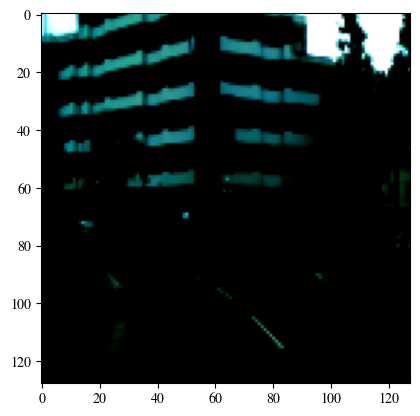

In [32]:
plt.imshow(left.permute(1,2,0))

Unnormalize

In [33]:
def unnormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    img_tensor: Tensor of shape [C, H, W]
    returns: numpy array [H, W, C] suitable for display
    """
    img = img_tensor.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img, 0, 1)  # For clean visualization
    return img


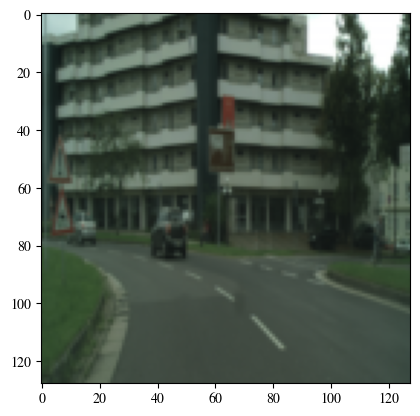

In [34]:
plt.imshow(unnormalize(left))

Shape Before: (800, 2048)
Shape After: (800, 2048)
Left shape: torch.Size([3, 128, 128]), Mask shape: torch.Size([128, 128]), Depth shape: torch.Size([1, 128, 128])


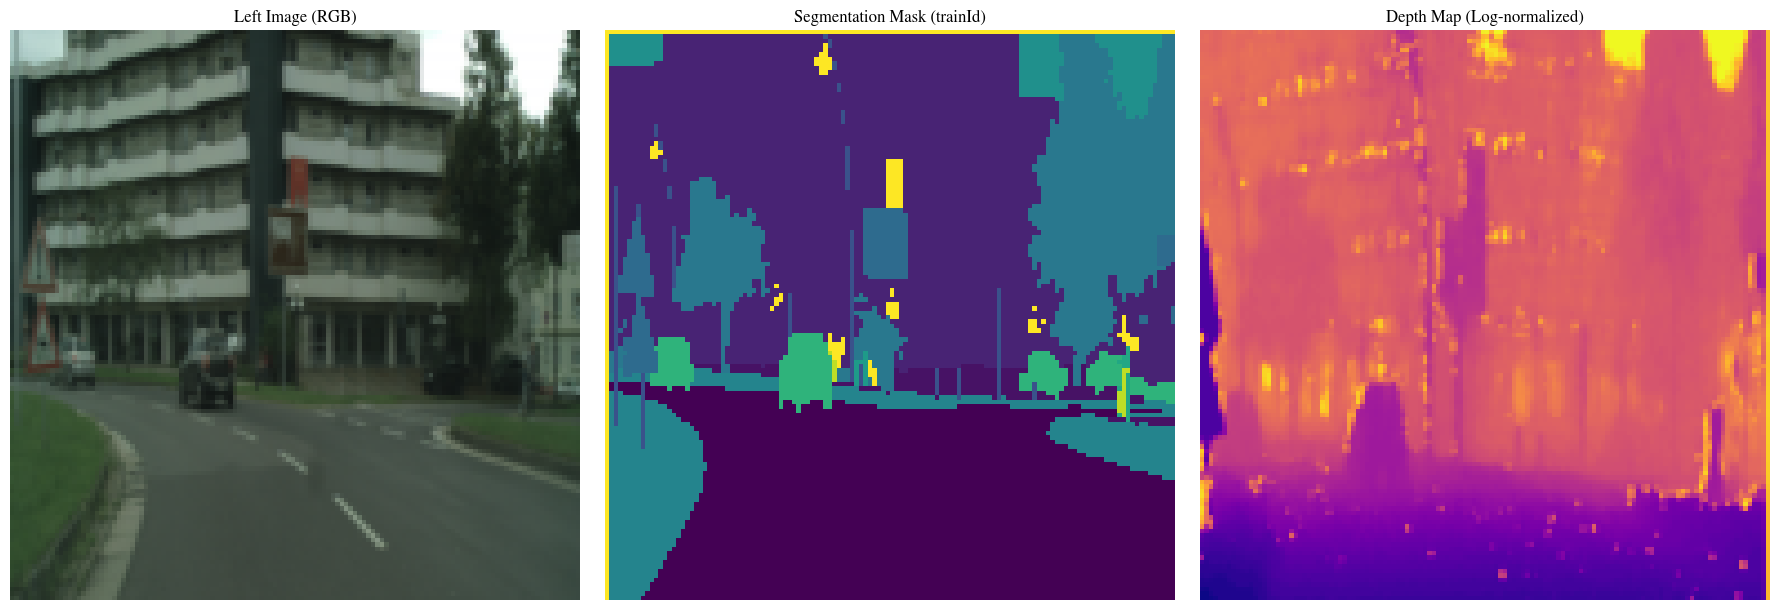

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch

sample = train_dataset[0]
left, mask, depth = sample['left'], sample['mask'], sample['depth']

print(f"Left shape: {left.shape}, Mask shape: {mask.shape}, Depth shape: {depth.shape}")

# Unnormalize RGB image
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
left_vis = (left * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()

# Convert mask and depth for display
mask_vis = mask.numpy()  # shape: (128, 128)
depth_vis = depth.squeeze().numpy()  # shape: (128, 128)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(left_vis)
axs[0].set_title("Left Image (RGB)")
axs[0].axis("off")

axs[1].imshow(mask_vis, cmap='viridis')
axs[1].set_title("Segmentation Mask (trainId)")
axs[1].axis("off")

axs[2].imshow(depth_vis, cmap='plasma')
axs[2].set_title("Depth Map (Log-normalized)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [36]:
import numpy as np

def colorize_mask(mask, colormap):
    """
    Convert a mask of trainIds to an RGB color image using a given colormap.

    Args:
        mask (np.ndarray): (H, W) array of trainIds.
        colormap (dict): Mapping from trainId to RGB tuple.

    Returns:
        np.ndarray: (H, W, 3) RGB image.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for train_id, color in colormap.items():
        color_mask[mask == train_id] = color

    return color_mask

cityscapes_trainid_to_color = {
    0:  (128, 64, 128),     # road
    1:  (244, 35, 232),     # sidewalk
    2:  ( 70, 70, 70),      # building
    3:  (102, 102, 156),    # wall
    4:  (190, 153, 153),    # fence
    5:  (153, 153, 153),    # pole
    6:  (250, 170, 30),     # traffic light
    7:  (220, 220, 0),      # traffic sign
    8:  (107, 142, 35),     # vegetation
    9:  (152, 251, 152),    # terrain
    10: (70, 130, 180),     # sky
    11: (220, 20, 60),      # person
    12: (255, 0, 0),        # rider
    13: (0, 0, 142),        # car
    14: (0, 0, 70),         # truck
    15: (0, 60, 100),       # bus
    16: (0, 80, 100),       # train
    17: (0, 0, 230),        # motorcycle
    18: (119, 11, 32),      # bicycle
    19: (0, 0, 142),        # license plate (ignoreInEval)
    20: (0, 0, 0)           # unlabeled / ignored
}

Shape Before: (800, 2048)
Shape After: (800, 2048)


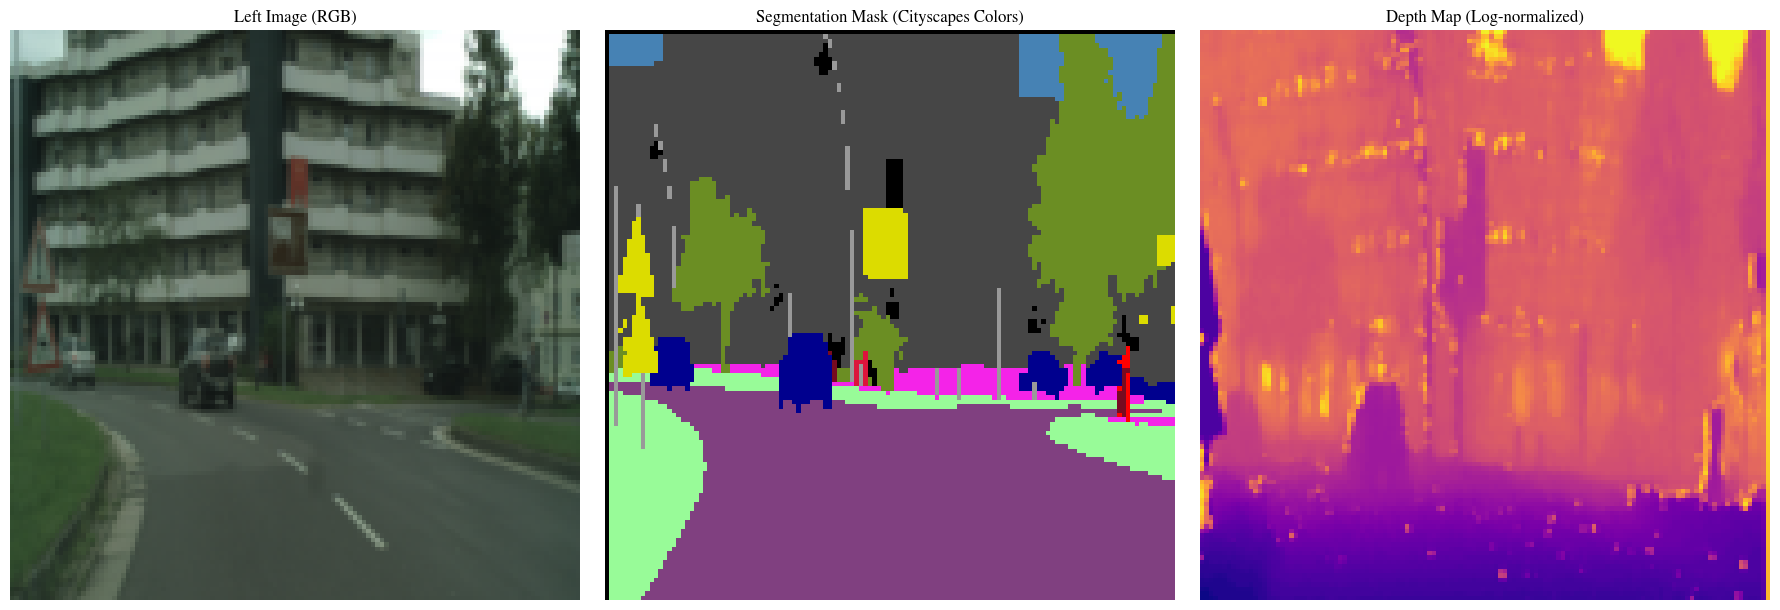

In [37]:
# Extract tensors
sample = train_dataset[0]
left, mask, depth = sample['left'], sample['mask'], sample['depth']

# Convert for plotting
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
left_vis = (left * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()

mask_vis = mask.numpy()  # shape: (H, W)
mask_rgb = colorize_mask(mask_vis, cityscapes_trainid_to_color)  # (H, W, 3)

depth_vis = depth.squeeze().numpy()  # (H, W)

# Plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(left_vis)
axs[0].set_title("Left Image (RGB)")
axs[0].axis("off")

axs[1].imshow(mask_rgb)
axs[1].set_title("Segmentation Mask (Cityscapes Colors)")
axs[1].axis("off")

axs[2].imshow(depth_vis, cmap='plasma')
axs[2].set_title("Depth Map (Log-normalized)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


Depth

In [39]:
depth.shape

torch.Size([1, 128, 128])

In [41]:
depth_pt = depth
depth = depth.numpy()

In [42]:
depth.min(), depth.max(), depth.mean(), depth.astype(np.float32).std()

(0.46051702, 1.1042922, 0.7794281, 0.1141159)

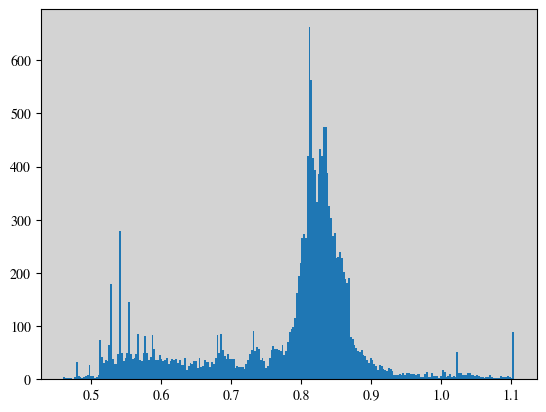

In [44]:
plt.hist(depth.flatten(), bins=250);

In [ ]:
"""
https://www.kaggle.com/code/curiousmohammed/multitask-train-depth/edit
"""